In [436]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

## 1. Getting data

In [437]:
def get_data():
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names

In [438]:
get_data()

--2022-11-04 17:31:29--  http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102815 (1.1M) [application/x-httpd-php]
Saving to: 'communities.data.2'

communities.data.2  100%[===================>]   1.05M  6.06MB/s    in 0.2s    

2022-11-04 17:31:29 (6.06 MB/s) - 'communities.data.2' saved [1102815/1102815]

--2022-11-04 17:31:29--  http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27179 (27K) [application/x-httpd-php]
Saving to: 'communities.names.2'

communities.names.2 100%[=================

In [460]:
#remove first 5 columns
df = pd.read_csv('communities.data', header=None, na_values='?')
for i in range(5):
    df.drop(df.columns[0], axis = 1, inplace=True)
# replace nan with median
df.fillna(df.median(), inplace=True)

In [440]:
# create target variable
Y = df[df.columns[-1]]
X = df.drop(Y.name, axis = 1)
X.shape # proper shape check

(1994, 122)

## 2. Split data

In [461]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=13)
x_train.shape

(1794, 122)

## 3. Scaling, NA's, EDA


In [469]:
# Min value for all columns is 0, max value for all except 65 is 1 so I scaled 65 to have the max be 1
print('Columns where max!=1:', [x for x in x_train if x_train[x].max() != 1])
print('Columns where min!=0:', [x for x in x_train if x_train[x].min() != 0])
x_train[65].describe()

Columns where max!=1: [65]
Columns where min!=0: []


count    1794.000000
mean        0.783016
std         0.228449
min         0.000000
25%         0.720000
50%         0.870000
75%         0.930000
max         0.990000
Name: 65, dtype: float64

In [443]:
# Univariate correlation between cols and target
Cors = []
for i in X.columns:
    Cors.append([i, np.corrcoef(X[i], Y)[0][1]])
Cors.sort(key = lambda x: abs(x[1])) # absolute value for general correlation
weakest = Cors[:5]
strongest = Cors[-5:]
print('\tWeakest\t\t\t\tStrongest')
print('Variable -> Correlation\t\t '*2)
for i in range(5):
    print(weakest[i][0],'->',weakest[i][1], '\t', strongest[4-i][0],'->',strongest[4-i][1])

	Weakest				Strongest
Variable -> Correlation		 Variable -> Correlation		 
124 -> 0.0037077469943642203 	 49 -> -0.7384238020704452
100 -> -0.019458936998681786 	 55 -> 0.7379565498586638
80 -> 0.021282828252731645 	 48 -> -0.7066674691569858
52 -> -0.02253536256167052 	 8 -> -0.684769576271543
6 -> -0.03492259533593247 	 50 -> -0.6660588959347973


## 4. Lasso

In [444]:
alpha=[1e-3, 1e-2, 1e-1, 1, 10]
for a in alpha:
    print(LassoCV(alphas=[a]).fit(x_train, y_train).score(x_test, y_test), a)
best_model = LassoCV(alphas = [1e-3]).fit(x_train, y_train)

0.7162857625214197 0.001
0.6371221658674413 0.01
-0.00112220234419258 0.1
-0.00112220234419258 1
-0.00112220234419258 10


In [473]:
features = [x_train.columns[i] for i in range(len(x_train.columns)) if best_model.coef_[i] > 0]
x_train[features].head() # only features chosen

,7,16,29,30,43,55,73,76,79,91,95,96,125
227,0.07,1.00,0.18,0.25,0.51,0.29,0.13,0.10,0.27,0.46,0.0,0.53,1.0
329,0.02,1.00,0.25,0.30,0.38,0.29,0.97,0.03,0.15,0.71,0.0,1.00,0.0
745,0.38,1.00,0.32,0.34,0.56,0.19,0.23,0.03,0.00,0.40,0.0,0.45,0.0
491,1.00,0.00,0.21,0.00,0.63,1.00,0.27,0.05,0.36,0.70,0.0,0.02,0.0
19,0.05,0.58,0.00,0.00,0.31,0.06,0.04,0.01,0.31,0.19,0.0,0.02,0.0


The best regularization constant was 0.001 with an $R^2$ value of 0.7163. This means our model was able to predict about 72% of the data\
Only 13 features were selected by this model and they were:\
7, 16,	29,	30,	43,	55,	73,	76,	79,	91,	95,	96 and 125.

The algebraic expression this model is minimizing is: \
$$L(\beta) = (y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^{p} |{\beta_j}| $$

## 5. Ridge

In [446]:
cv = KFold(n_splits=10, random_state=13, shuffle=True)
for a in alpha:
    print(RidgeCV(cv=cv, alphas = [a]).fit(x_train, y_train).score(x_test, y_test), a)
best_rid = RidgeCV(cv=cv, alphas = [1])

0.7201135503467768 0.001
0.7211898081435186 0.01
0.7249030825581628 0.1
0.7300563320958668 1
0.7269277448684428 10


The best constant for Ridge is 1 with an $R^2$ of 0.7301. 

The algebraic expression this model is minimizing is: \
$$L(\beta) = (y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^{p} {\beta_j}^2 $$

I think Ridge is simpler because it doesn't drop to 0 when the alpha gets big so you don't need to do extra work to find out what happened. It also has higher $R^2$ values.

## 6. Random Forest

In [474]:
max_depth = [int(x) for x in np.linspace(6, 20, num = 10)]
max_features = [x for x in np.linspace(0.1, 1, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(6, 20, num = 10)]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [475]:
m = RandomizedSearchCV(n_iter=100, n_jobs=-1, cv=cv, random_state=123,
                       estimator=RandomForestRegressor(),
                       param_distributions=random_grid)


In [477]:
rf = m.fit(x_train, y_train)

In [478]:
rf.best_estimator_ # Best hyper parameters.

RandomForestRegressor(max_depth=10, max_features=0.30000000000000004,
                      min_samples_leaf=6)

The best hyper parameters are max_depth=10, max_features=0.2, min_samples_leaf=6)\
They tell us that we needed a medium depth, 20% of the features, and

In [479]:
rf.score(x_test, y_test) # R^2

0.7174242844968342

## 7. Model Selection
The statistic that cross-validation functions use is $R^2$. Based on that criterion, Random Forests worked the best since it had the highest score. 

I think the best in terms of simplicity and interpretability, Ridge is the best because it had the second highest score and is easier to visualize than Random Forests in relation to $\hat{\beta}$ estimation. 

I think the scores between all 3 models are comparable although Lasso reduces some features to 0 which may lower the $R^2$ value but may increase predictability. 

Ridge does include the 5 features with the strongest univariate correlation with the target so that needs to be taken into account when predicting or classifying significant predictors. 


## 8. Evaluation


In [480]:
final_model = best_rid.fit(x_train, y_train)
final_model.score(x_test, y_test) # R^2 value

0.7300563320958668

I think this estimate of $R^2$ is optimistic because if there is univariate correlation our significant predictors may be off and we could possibly be overfitting the model which would give us a higher but more untrustworthy $R^2$

In [484]:
scores = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X,
                                                        Y, test_size=0.10,
                                                        random_state=i**3)
    scores.append(best_rid.fit(x_train, y_train).score(x_test, y_test))
scores = pd.Series(scores)  

Text(0.5, 0, 'R^2 values')

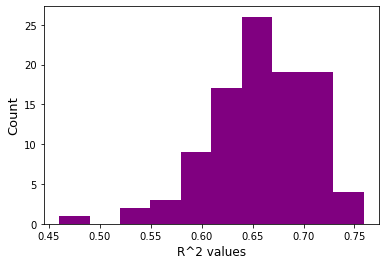

In [485]:
scores.values
plt.hist(scores, color = 'purple')
plt.ylabel('Count', size = 13)
plt.xlabel('R^2 values', size = 12)

My confidence interval for the true value of $R^2$ is [0.58, 0.72] which would put my original $R^2$ on the higher end of probabilities or an outlier. 